In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from decimal import Decimal
from typing import List, Tuple
from warnings import warn

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml
from ogb.nodeproppred import PygNodePropPredDataset

import tqdm
tqdm.tqdm.pandas()

In [4]:
from notebooks import mpl_latex

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [5]:
mpl_latex.enable_production_mode()

In [6]:
log_margin = np.linspace(-1.5, 1.5, 1001)
log_margin

array([-1.5  , -1.497, -1.494, ...,  1.494,  1.497,  1.5  ])

In [13]:
loss_map = {
    'CE': 'CE',
    'CW': 'CW',
    'SCE': 'SCE',
    'MCE': 'MCE',
    'tanhMargin': 'tanh Margin',
    'Margin': 'Margin',
    'eluMargin': 'elu Margin',
    'tanhMarginMCE-0.5': 'Composite',
    'tanhMarginMCE-0.75': 'Composite',
}

loss_funcs = {
    'CE': lambda log_margin: -log_margin / 2 + np.log(np.exp(- log_margin / 2) + np.exp(log_margin / 2)),
    'CW': lambda log_margin: -np.clip(log_margin, 0, None),
    'SCE': lambda log_margin: -log_margin / 2 - np.log(np.exp(- log_margin / 2) + np.exp(log_margin / 2)),
    'MCE': lambda log_margin: np.where(log_margin >= 0, - log_margin / 2 + np.log(np.exp(- log_margin / 2) + np.exp(log_margin / 2)), np.log(2)),
    'tanhMargin': lambda log_margin: np.tanh(-log_margin),
    'Margin': lambda log_margin: -log_margin,
    'eluMargin': lambda log_margin: -np.exp(np.clip(log_margin, None, 0)) + 1 - np.clip(log_margin, 0, None)
}

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


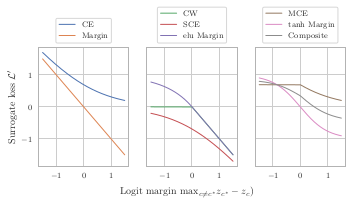

In [16]:
loss_groups = [['CE', 'Margin'], ['CW', 'SCE', 'eluMargin'], ['MCE', 'tanhMargin', 'tanhMargin_MCE_0.5']]
fig, axes = mpl_latex.newfig(width=1, ratio_yx=0.4, ncols=len(loss_groups), sharey=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_idx = 0

for ax, loss_group in zip(axes, loss_groups):
    for loss_name in loss_group:
        
        comps = loss_name.split('_')
        if not all(comp in loss_funcs for comp in comps[:-1]):
            continue
        elif len(comps) == 1:
            loss_value = loss_funcs[loss_name](log_margin)
            label = loss_map[loss_name]
        elif len(comps) % 2 == 1:
            losses = comps[:len(comps) // 2 + 1]
            alphas = [float(alpha) for alpha in comps[len(comps) // 2 + 1:]]
            alphas.append(1 - sum(alphas))
            loss_value = sum([alpha * loss_funcs[loss](log_margin) for alpha, loss in zip(alphas, losses)])
            label = 'Composite'
            #label = ' + '.join([f'{alpha} {loss_map[loss]}' for alpha, loss in zip(alphas, losses)])
            
        ax.plot(log_margin, loss_value, label=label, color=colors[color_idx])
        ax.legend(loc='lower center', ncol=1, bbox_to_anchor=(0.5, 1.))
        color_idx += 1
        color_idx %= len(colors)

fig.text(0.5, -0.05, r'Logit margin $\text{max}_{c \ne c^*} z_{c^*} - z_{c})$', ha='center')
axes[0].set_ylabel(r"Surrogate loss $\mathcal{L}'$")
        
#handles = []
#labels = []
#for ax in axes:
#    handles.extend(ax.get_legend_handles_labels()[0])
#    labels.extend(ax.get_legend_handles_labels()[1])

#fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.))

mpl_latex.savefig(f'latex/assets/compare_losses_binary', fig, close_fig=False)

plt.gcf()